## Hello World

This will be my test bench for testing and relearning PyTorch

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

Next up, I'm downloading one of their multitude of datasets. Whose? Facebook's (who have collected a bunch from other sources into a single API call kinda thing hahahahahhaa)

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Below is to load the data into something workable for PyTorch

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Now we will define our model

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to("cpu")
print(model)

For training our model, we need some loss function and optimizer function for the model to 'learn'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

This is our training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to("cpu"), y.to("cpu")

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

... and this is our testing function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("cpu"), y.to("cpu")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


... and finally this is to run the whole thing

In [ ]:
epochs = 8
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
model.eval()
for i in range(1, cols * rows + 1):
    
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    x, y = test_data[sample_idx][0], test_data[sample_idx][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        
        figure.add_subplot(rows, cols, i)
        txt = f'Predicted: "{predicted}", \nActual: "{actual}"'
        plt.title(txt)
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap="gray")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


## Start of FYP testing on Fruit Recognition
Below will be the code for preparing the dataset for ML

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

REBUILD_DATA = True
IMG_SIZE = 100

class fruitification():
    
    """
    STEPS:
    1) Denote the file directory for Apples, Mangoes, Bananas, Grapes and Strawberries
    2) Label them with a dictionary. We'll use np.eye to handle the labelling into the training_data
    3) Training_data = []
    4) Count how many fruits for each Apples, Mangoes, etc...
    5) Shuffle the training_data
    6) Save it
    """
    
    # IMG_SIZE dictates the dimensions we wanna resize it into i.e. 50x50
    IMG_SIZE = 100
    
    # Directory of fruits
    AP = "fruits/apple"
    BN = "fruits/banana"
    GR = "fruits/grape"
    MG = "fruits/mango"
    ST = "fruits/strawberry"
    
    # Labels for fruits in numbers
    LABELS = {AP: 0, BN: 1, GR: 2, MG: 3, ST: 4}
    training_data = []
    counts = [0, 0, 0, 0, 0]
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # Access the individual images inside each directory folder
            for f in tqdm(os.listdir(label)):
                try:
                    # Create the full path name here
                    path = os.path.join(label, f)
                    img = cv2.imread(path)
                    # By default, opencv2 reads an image in BGR format
#                     img = cv2.imread(path) 
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    
                    # eye is identity matrix. self.LABELS[label] is just dictionary and key accessing
                    self.training_data.append([np.flip(np.array(img), axis=-1), np.eye(5)[self.LABELS[label]]])
                    # np.flip axis = -1 essentially flips BGR to RGB. Inverted flip kinda thing y'know
                    
                    # Count each fruit
                    self.counts[self.LABELS[label]] += 1
                        
                except:
                    pass
                
        # shuffling, cuz I heard it helps reduce the model from memorizing patterns
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(len(self.training_data))
        
        # printing the count for each fruits
        for i in self.LABELS:
            print(i[7:], ":", self.counts[self.LABELS[i]])

if REBUILD_DATA:
    fds = fruitification()
    print("Making...")
    fds.make_training_data()
    REBUILD_DATA = False

Making...
fruits/apple


100%|██████████| 1203/1203 [00:01<00:00, 1084.07it/s]


fruits/banana


100%|██████████| 1162/1162 [00:01<00:00, 1001.74it/s]


fruits/grape


100%|██████████| 1033/1033 [00:01<00:00, 1028.86it/s]


fruits/mango


100%|██████████| 1025/1025 [00:00<00:00, 1032.39it/s]


fruits/strawberry


100%|██████████| 1002/1002 [00:01<00:00, 958.54it/s]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


5425
apple : 1203
banana : 1162
grape : 1033
mango : 1025
strawberry : 1002


[0. 0. 0. 0. 1.]


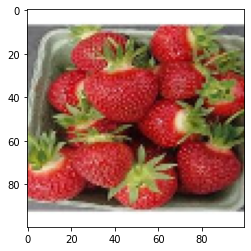

(100, 100, 3)


In [2]:
training_data = np.load("training_data.npy", allow_pickle = True)
                        
# training_data[...][0] ==> the actual image in array format
# training_data[...][1] ==> the label of image
idx = 5

plt.imshow(training_data[idx][0])
print(training_data[idx][1])
plt.show()
print(training_data[1][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5425, 100, 100, 3])


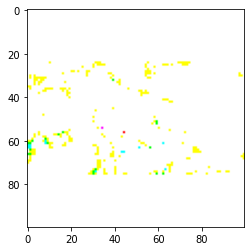

torch.Size([5425, 100, 100, 3])


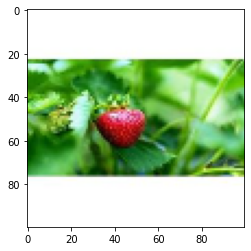

In [5]:
# # if .Tensor, no need the , 1 after -1
# print(the_data.shape)
the_data = torch.Tensor([i[0] for i in training_data]).view(-1, IMG_SIZE, IMG_SIZE, 3)

# print(the_data[1])
print(the_data.shape)
plt.imshow(the_data[1])
plt.show()

# # "Normalize" it into values between 0 and 1. Easier to train the model
the_data = the_data/255.0

# print(the_data[1])
print(the_data.shape)
plt.imshow(the_data[1])
plt.show()

labellings = torch.Tensor([i[1] for i in training_data])

validation_perc = 0.1
validation_size = int(len(the_data) * validation_perc)

# # Basically 90% is for training
train_x = the_data[:-validation_size]
train_y = labellings[:-validation_size]

# # 10% for testing
test_x = the_data[-validation_size:]
test_y = labellings[-validation_size:]

In [6]:
print(the_data.shape)
print(labellings.shape)

torch.Size([5425, 100, 100, 3])
torch.Size([5425, 5])


In [14]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) # image channel == 1, output channel == 6, kernel filter == 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5) 
        self.fc1 = nn.Linear(16 * 22 * 22, 64) # 16 cuz from conv2, 5 and 5 cuz of our kernel filters above
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 5)
        
#         self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.softmax(x, dim=1)
#         return x


model = NeuralNet()

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(train_x.shape)
print(train_y.shape)

torch.Size([4883, 100, 100, 3])
torch.Size([4883, 5])


In [16]:
BATCH_SIZE = 100
EPOCHS = 55

# Training time
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        batch_x = train_x[i: i+BATCH_SIZE].view(-1, 3, IMG_SIZE, IMG_SIZE)
        batch_y = train_y[i: i+BATCH_SIZE]
        
        model.zero_grad()
        
#         print(batch_x.shape)
        outputs = model(batch_x)
#         print(outputs.shape)
#         print(batch_y.shape)
        loss = loss_fn(outputs, torch.max(batch_y, 1)[1])
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}. Loss: {loss}")

100%|██████████| 49/49 [00:09<00:00,  5.42it/s]


Epoch: 1. Loss: 1.5456520318984985


100%|██████████| 49/49 [00:08<00:00,  5.77it/s]


Epoch: 2. Loss: 1.5053514242172241


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 3. Loss: 1.5043814182281494


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 4. Loss: 1.5003113746643066


100%|██████████| 49/49 [00:08<00:00,  5.93it/s]


Epoch: 5. Loss: 1.5378481149673462


100%|██████████| 49/49 [00:08<00:00,  5.92it/s]


Epoch: 6. Loss: 1.5011078119277954


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 7. Loss: 1.46152663230896


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]


Epoch: 8. Loss: 1.4331958293914795


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 9. Loss: 1.4145454168319702


100%|██████████| 49/49 [00:08<00:00,  5.91it/s]


Epoch: 10. Loss: 1.4173084497451782


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 11. Loss: 1.396451473236084


100%|██████████| 49/49 [00:08<00:00,  5.90it/s]


Epoch: 12. Loss: 1.4033185243606567


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 13. Loss: 1.4087882041931152


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 14. Loss: 1.4015042781829834


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 15. Loss: 1.3907629251480103


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 16. Loss: 1.3569915294647217


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 17. Loss: 1.348308801651001


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 18. Loss: 1.3219757080078125


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 19. Loss: 1.361404299736023


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 20. Loss: 1.3991754055023193


100%|██████████| 49/49 [00:08<00:00,  5.80it/s]


Epoch: 21. Loss: 1.4156749248504639


100%|██████████| 49/49 [00:08<00:00,  5.91it/s]


Epoch: 22. Loss: 1.399799108505249


100%|██████████| 49/49 [00:08<00:00,  5.83it/s]


Epoch: 23. Loss: 1.3969953060150146


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 24. Loss: 1.3697245121002197


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 25. Loss: 1.3670122623443604


100%|██████████| 49/49 [00:08<00:00,  5.90it/s]


Epoch: 26. Loss: 1.347028136253357


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 27. Loss: 1.3212999105453491


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 28. Loss: 1.3185116052627563


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 29. Loss: 1.310057282447815


100%|██████████| 49/49 [00:08<00:00,  5.90it/s]


Epoch: 30. Loss: 1.2964600324630737


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 31. Loss: 1.277431845664978


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 32. Loss: 1.2532527446746826


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 33. Loss: 1.2654558420181274


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 34. Loss: 1.2409230470657349


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 35. Loss: 1.2763549089431763


100%|██████████| 49/49 [00:08<00:00,  5.82it/s]


Epoch: 36. Loss: 1.245398759841919


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 37. Loss: 1.2409019470214844


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 38. Loss: 1.2336848974227905


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Epoch: 39. Loss: 1.2237968444824219


100%|██████████| 49/49 [00:08<00:00,  5.84it/s]


Epoch: 40. Loss: 1.220123529434204


100%|██████████| 49/49 [00:08<00:00,  5.90it/s]


Epoch: 41. Loss: 1.2286555767059326


100%|██████████| 49/49 [00:08<00:00,  5.84it/s]


Epoch: 42. Loss: 1.237114429473877


100%|██████████| 49/49 [00:08<00:00,  5.88it/s]


Epoch: 43. Loss: 1.2236613035202026


100%|██████████| 49/49 [00:08<00:00,  5.87it/s]


Epoch: 44. Loss: 1.208322286605835


100%|██████████| 49/49 [00:08<00:00,  5.69it/s]


Epoch: 45. Loss: 1.2630200386047363


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]


Epoch: 46. Loss: 1.2790452241897583


100%|██████████| 49/49 [00:08<00:00,  5.77it/s]


Epoch: 47. Loss: 1.2629255056381226


100%|██████████| 49/49 [00:08<00:00,  5.79it/s]


Epoch: 48. Loss: 1.303983211517334


100%|██████████| 49/49 [00:08<00:00,  5.73it/s]


Epoch: 49. Loss: 1.2405509948730469


100%|██████████| 49/49 [00:08<00:00,  5.82it/s]


Epoch: 50. Loss: 1.2483519315719604


100%|██████████| 49/49 [00:08<00:00,  5.75it/s]


Epoch: 51. Loss: 1.2299400568008423


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]


Epoch: 52. Loss: 1.2311201095581055


100%|██████████| 49/49 [00:08<00:00,  5.78it/s]


Epoch: 53. Loss: 1.2167415618896484


100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch: 54. Loss: 1.2994637489318848


100%|██████████| 49/49 [00:09<00:00,  5.39it/s]

Epoch: 55. Loss: 1.2853271961212158


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = model(test_x[i].view(-1, 3, IMG_SIZE, IMG_SIZE)) # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3)*100)

100%|██████████| 542/542 [00:00<00:00, 681.49it/s]

Accuracy:  57.199999999999996


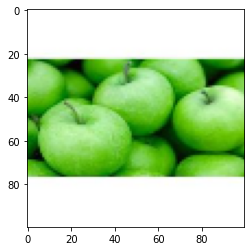

Predicted:  Apple
Actual:  Apple


In [23]:
index = 19
actual_img = test_x[index]

plt.imshow(actual_img, cmap="gray")
plt.show()

# torch.argmax returns the indices with the highest probability
actual_label = torch.argmax(test_y[index])
network_output = model(test_x[index].view(-1, 3, IMG_SIZE, IMG_SIZE))
predicted_label = torch.argmax(network_output)
# print(network_output)
# print(predicted_label)

l = ["Apple", "Banana", "Grape", "Mango", "Strawberry"]
print("Predicted: ", l[predicted_label.item()])
print("Actual: ", l[actual_label.item()])